In [1]:
from glasflow.flows import RealNVP
import sklearn.datasets as datasets
import matplotlib.pyplot as plt

import torch
from torch import optim

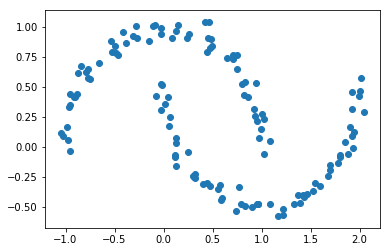

In [2]:
x, y = datasets.make_moons(128, noise=.05)
plt.scatter(x[:, 0], x[:, 1]);

In [3]:
flow = RealNVP(n_inputs=2,
        n_transforms=5,
        n_neurons=32,
        batch_norm_between_transforms=True)

In [4]:
optimizer = optim.Adam(flow.parameters())

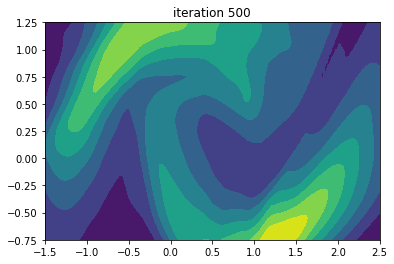

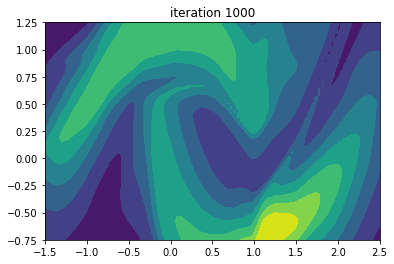

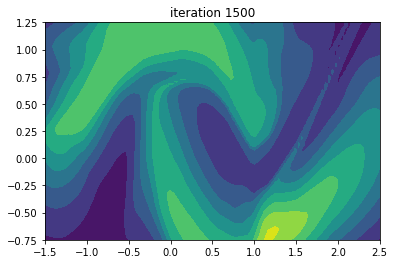

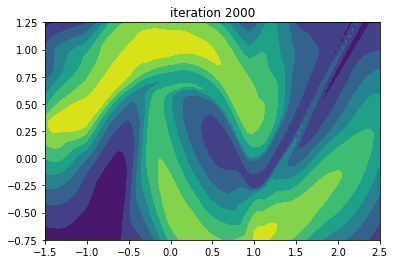

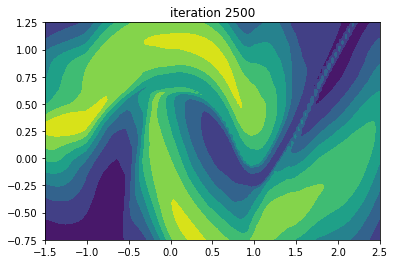

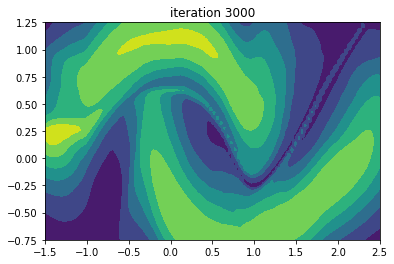

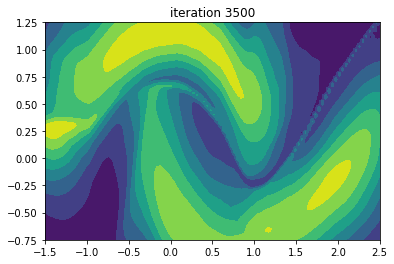

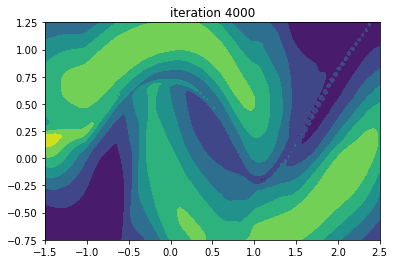

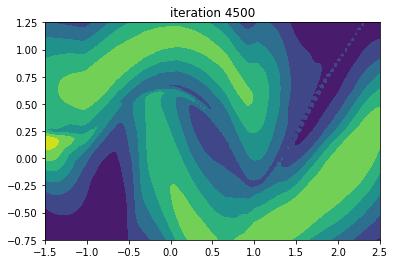

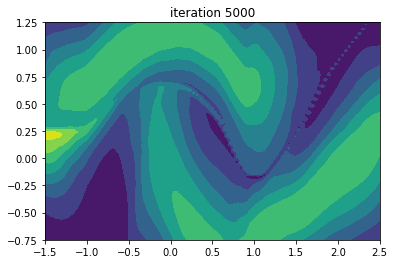

In [5]:
num_iter = 5000
train_loss = []

for i in range(num_iter):
    t_loss = 0
    
    x, y = datasets.make_moons(128, noise=.1)
    x = torch.tensor(x, dtype=torch.float32)
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=x).mean()
    loss.backward()
    optimizer.step()
    t_loss += loss.item()
    
    if (i + 1) % 500 == 0:
        xline = torch.linspace(-1.5, 2.5, 100)
        yline = torch.linspace(-.75, 1.25, 100)
        xgrid, ygrid = torch.meshgrid(xline, yline)
        xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

        with torch.no_grad():
            zgrid = flow.log_prob(xyinput).exp().reshape(100, 100)

        plt.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy())
        plt.title('iteration {}'.format(i + 1))
        plt.show()
        
    train_loss.append(t_loss)

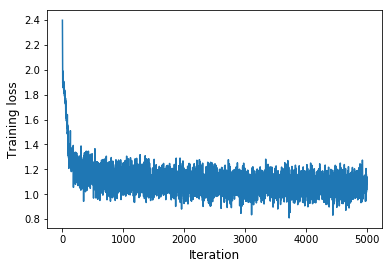

In [15]:
plt.plot(train_loss);
plt.xlabel('Iteration', fontsize=12);
plt.ylabel('Training loss', fontsize=12);


In [16]:
n_samples = 128
size = 2 

flow.eval()
with torch.no_grad():
    # flow predictions from Gaussian latent space
    z = torch.randn(n_samples, size)
    samples, log_prob = flow.inverse(z)
    # latent space mapping on training data
    z_ , _= flow.forward(x)

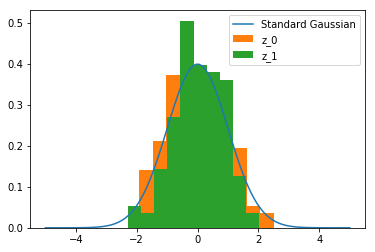

In [25]:
from scipy.stats import norm
import numpy as np

g = np.linspace(-5, 5, 100)
plt.plot(g, norm.pdf(g), label='Standard Gaussian')

plt.hist(z_[:,0], density=True, label='z_0');
plt.hist(z_[:,1], density=True, label='z_1');
plt.legend();

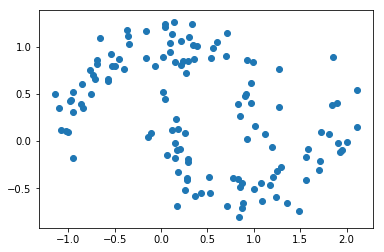

In [19]:
plt.scatter(samples[:, 0], samples[:, 1]);